#MMDM Lab 2

##Problem 1:

Functional to minimise: $$J(u) = \int_{0}^{1} [(\frac{du}{dx})^2-2 \lambda e^u]dx \\ u(0)=u(1)=0$$<br>
$$\min_{u} J(u)=?,~u=?$$

$u$ is an extrema of $J$ if it verifies `Euler-Lagrange equation` (necessary condition).
$$L=(\frac{du}{dx})^2-2 \lambda e^u=(u')^2-2 \lambda e^u\\
\dfrac{\partial L}{\partial u} - \dfrac{d}{dx}(\dfrac{\partial L}{\partial u'}) = 0
$$

After calculations I got the following equation: $$\frac{d^2u}{dx^2}+\lambda e^u=0 \\
 u(0)=u(1)=0$$

Now, we use the `the Shooting method` to solve for $u$.<br>
First, we import the required librairies:

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

We implement the following function to introduce a variable $v=\frac{du}{dx}$ and define the new system of ODEs: $$\frac{du}{dx}=v \\ \frac{dv}{dx}=-\lambda e^u$$

In [ ]:
#Define the system of ODEs
def odes(x, y, lambda_):
    u, v = y
    return [v, -lambda_ * np.exp(u)]

A solver function to solve the ODEs system given with `u(0)` value and the guess of `v(0)` (of course, $v=\frac{du}{dx}$).

In [ ]:
#Define the shooting function that gets f(1) according to our f_prime_0 value
def shooting_method(lambda_, u0, guess_v0):
    sol = solve_ivp(odes, [0, 1], [u0, guess_v0], args=(lambda_,), dense_output=True)
    #Get f(1)
    u1 = sol.sol(1)[0]
    return u1

Now, we implement the Shooting method (that uses the Newton method), to try and find the right value of `v(0)` that will give us the target boudary condition `u(1)=0`:

In [ ]:
def newton_shooting(lambda_, u0, u1_target, initial_guess, tol=1e-6, max_iter=500):
    v0 = initial_guess
    #u1 is a function of v0: u1=f(v0)
    #We need to find a solution v0 such that u1=shooting_method(..., v0)=0
    for i in range(max_iter):
        u1 = shooting_method(lambda_, u0, v0)
        if abs(u1 - u1_target) < tol:
            #print(f"Converged in {i} iterations")
            return v0

        #Numerical derivative
        delta = 1e-8
        u1_prime = (shooting_method(lambda_, u0, v0 + delta) - u1) / delta

        #Update v0 using the Newton method
        v0 -= (u1 - u1_target) / u1_prime

    raise RuntimeError("Shooting method did not converge and reached the maximum number of iterations!")

Let's execute the shooting method to find the solution for $\lambda=1$:

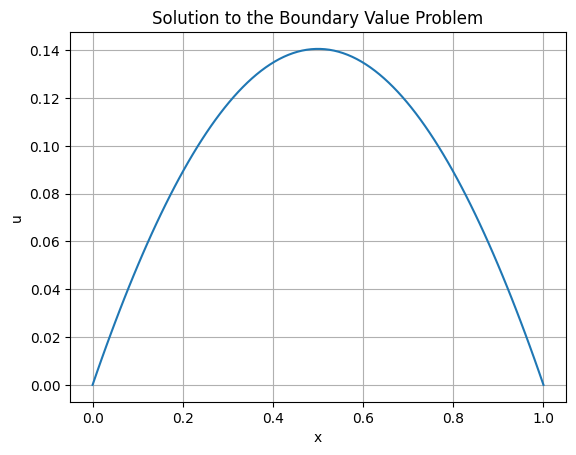

In [ ]:
#Parameters
lambda_ = 1.0
u0 = 0.0
u1_target = 0.0
initial_guess = 0.5

#Solve for v=du/dx
v0 = newton_shooting(lambda_, u0, u1_target, initial_guess)

#Integrate the ODE with the found initial derivative
sol = solve_ivp(odes, [0, 1], [u0, v0], args=(lambda_,), dense_output=True)
x = np.linspace(0, 1, 100)
u = sol.sol(x)[0]

#Plot the solution
plt.plot(x, u)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Solution to the Boundary Value Problem')
plt.grid(True)
plt.show()

And now let's see the minimum value of our functional $J$:

In [ ]:
#Calculate the functional J(u)
def integrand(x, u, u_prime, lambda_):
    return u_prime**2 - 2 * lambda_ * np.exp(u)

u_prime = sol.sol(x)[1]
J = np.trapz(integrand(x, u, u_prime, lambda_), x)

print(f"Minimum found for the functional J(u): {J}")

Minimum found for the functional J(u): -2.0930357069459107


Let us now try and find the bifurcation points, the values of $\lambda$ for which the determinant of the matrix of derivatives in Newton's method is 0.

The Jacobian determinant for the newton shooting result:

In [ ]:
def jacobian_determinant(lambda_, u0, u1_target, initial_guess):
    v0 = newton_shooting(lambda_, u0, u1_target, initial_guess)
    delta = 1e-8
    u1_prime = (shooting_method(lambda_, u0, v0 + delta) - shooting_method(lambda_, u0, v0)) / delta
    return u1_prime

After few tries, I found the determinant tends to 0 after $\lambda$ exceeds `3.5`. More precisely, the solver can't solve anymore a little after $\lambda$ reaches $\lambda=3.525$. Let's try to approach the bifurcation value as best as we could:

In [ ]:
u0 = 0.0
u1_target = 0.0
initial_guess = 0.5

# Continuation method to find bifurcation points
lambda_values = np.linspace(3.525, 3.526, 1000)
jacobian_dets = []
count = 0
for lambda_ in lambda_values:
    try:
        det = jacobian_determinant(lambda_, u0, u1_target, initial_guess)
        #print(f'Lambda = {lambda_}, and determinant = {det}')
        jacobian_dets.append(det)
    except RuntimeError:
        jacobian_dets.append(np.nan)
        #print(f'Lambda = {lambda_}, and determinant = {np.nan}')
        count += 1
        if count > 5:
            break

# Detect bifurcation points where the Jacobian determinant is close to zero
bifurcation_points = [(lambda_, det) for lambda_, det in zip(lambda_values, jacobian_dets) if abs(det) < 1e-3]
if bifurcation_points:
    b_points = [f'(lambda={lmbd}, det={det_})' for lmbd, det_ in bifurcation_points]
    print(f"Bifurcation points: {b_points}")
else:
    print('No bifurcation points detected...')
#bifurcation_lambda = lambda_values[np.argmin(np.abs(jacobian_dets))]
#print(f"Bifurcation point = {round(bifurcation_lambda,2)}")

Bifurcation points: ['(lambda=3.5258068068068065, det=0.0009490380703525148)', '(lambda=3.5258078078078077, det=0.0008587242028568198)', '(lambda=3.5258088088088084, det=0.0007631090204185398)', '(lambda=3.5258098098098096, det=0.0006614014891326292)', '(lambda=3.525810810810811, det=0.00022946089472952735)', '(lambda=3.5258118118118116, det=-6.869227409112e-05)']


In [ ]:
jacobian_dets = jacobian_dets+[np.nan]*(len(lambda_values)-len(jacobian_dets))
print(len(jacobian_dets))

1000


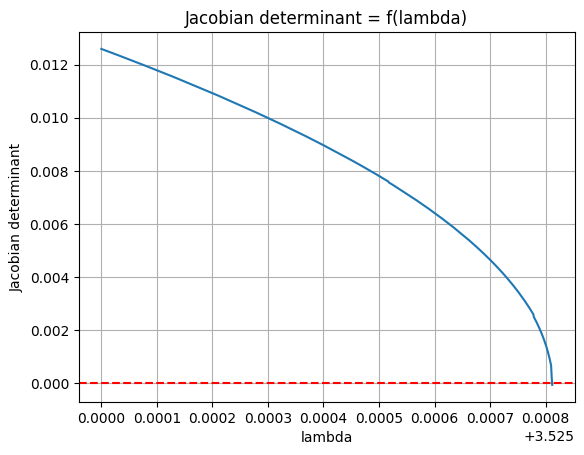

In [ ]:
# Plot the determinant of the Jacobian
plt.plot(lambda_values, jacobian_dets)
plt.xlabel('lambda')
plt.ylabel('Jacobian determinant')
plt.title('Jacobian determinant = f(lambda)')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

From the previous analysis, the bifurcation point is around $\lambda=3.5258$

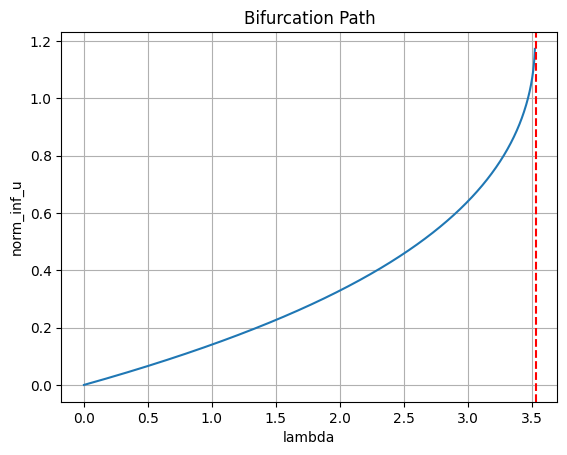

In [ ]:
# Parameters
lambdas = np.linspace(0, 4, 4000)
u0 = 0.0
u1_target = 0.0
initial_guess = 0.5
max_u_values = []

# Solve for each lambda
for lambda_ in lambdas:
    try:
      v0 = newton_shooting(lambda_, u0, u1_target, initial_guess)
      sol = solve_ivp(odes, [0, 1], [u0, v0], args=(lambda_,), dense_output=True)
      x = np.linspace(0, 1, 100)
      u = sol.sol(x)[0]
      max_u_values.append(np.max(u))
    except RuntimeError:
      max_u_values.append(np.nan)
      break
max_u_values = max_u_values + [np.nan]*(len(lambdas)-len(max_u_values))
# Plot the bifurcation path
plt.plot(lambdas, max_u_values)
plt.xlabel('lambda')
plt.ylabel('norm_inf_u')
plt.title('Bifurcation Path')
plt.axvline(3.53, color='red', linestyle='--')
plt.grid(True)
plt.show()

We notice as the value of $\lambda$ approaches the critical value found earlier, the norm infinity starts diverging. Therefore we can say that this bifurcation point changes the nature of the solution and makes it go from bounded to unbounded with its infinity norm diverging towards infinity.

##Problem 2:

The functional to minimise is:
$$J(u)=\int_{0}^{1} \int_{0}^{1} [~(\frac{\partial u}{\partial x})^2+(\frac{\partial u}{\partial y})^2 - 4\pi^2 sin(\pi x) sin(\pi y) u(x,y)~] ~ dxdy\\
u(0,y) = u(1,y) = u(x,0) = u(x,1) = 0
$$

To solve this we assume u is of the form $u(x,y) = h(x)g(y)$ and variate $J$ with respect to $h$ and $g$ seperately (by applying Euler-Lagrange), then we obtain 2 boundary value problems for ODEs for both functions $h$ and $g$.
$$
J(h,g)=\int_{0}^{1} \int_{0}^{1} [~h'^{2} g^2+ g'^{2} h^2 - 4\pi^2 sin(\pi x)~h(x)~sin(\pi y)~g(y)~] ~ dxdy\\
L_x(h,h') = \int_{0}^{1} [~h'^{2} g^2+ g'^{2} h^2 - 4\pi^2 sin(\pi x)~h(x)~sin(\pi y)~g(y)~] ~ dy\\
L_y(g,g') = \int_{0}^{1} [~h'^{2} g^2+ g'^{2} h^2 - 4\pi^2 sin(\pi x)~h(x)~sin(\pi y)~g(y)~] ~ dx\\
\text{Euler-Lagrange equation (for x or y variable): } \dfrac{\partial L}{\partial f} - \dfrac{d}{dx}(\dfrac{\partial L}{\partial f'}) = 0
$$

After calculations we get: first, the boundary value problem for h.
$$
C_1 \dfrac{d^2h}{dx^2} - C_2~h + 2 C_3 \pi^2 sin(\pi x)=0\\
h(0) = h(1) = 0\\
C_1 = \int_{0}^{1} g^2 dy\\
C_2 = \int_{0}^{1} g'^2 dy\\
C_3 = \int_{0}^{1} sin(\pi y)g(y) dy\\
$$

Second, the boundary value problem for g.
$$
K_1 \dfrac{d^2g}{dy^2} - K_2~g + 2 K_3 \pi^2 sin(\pi y)=0\\
g(0) = g(1) = 0\\
K_1 = \int_{0}^{1} h^2 dx\\
K_2 = \int_{0}^{1} h'^2 dx\\
K_3 = \int_{0}^{1} sin(\pi x)h(x) dx\\
$$

The modified shooting method functions for this problem:

In [ ]:
#Define the system of ODEs
def odes_(t, y, c1, c2, c3):
    f, f_prime = y
    return [f_prime, (c2/c1) * f - (2 * np.pi**2 * c3/c1) * np.sin(np.pi * t)]

#Define the shooting function that gets f(1) according to our f_prime_0 value
def shooting_method_(c1, c2, c3, f0, guess_f_prime0):
    sol = solve_ivp(odes_, [0, 1], [f0, guess_f_prime0], args=(c1, c2, c3), dense_output=True)
    #Get f(1)
    f1 = sol.sol(1)[0]
    return f1

#The Newton method for shooting
def newton_shooting_(c1, c2, c3, f0, f1_target, initial_guess, tol=1e-4, max_iter=1000):
    f_prime0 = initial_guess
    for i in range(max_iter):
        f1 = shooting_method_(c1, c2, c3, f0, f_prime0)
        if abs(f1 - f1_target) < tol:
            return f_prime0

        # Numerical derivative
        delta = 1e-8
        f1_prime = (shooting_method_(c1, c2, c3, f0, f_prime0 + delta) - f1) / delta

        # Update f_prime0 using Newton's method
        f_prime0 -= (f1 - f1_target) / f1_prime

    raise RuntimeError("Newton method did not converge within the maximum number of iterations")


#Calculate integrals to find coefficients
def calculate_coefficients_h(g, g_prime, y):
    c1 = np.trapz(g**2, y)
    c2 = np.trapz(g_prime**2, y)
    c3 = np.trapz(np.sin(np.pi*y) * g, y)
    return c1, c2, c3

def calculate_coefficients_g(h, h_prime, x):
    k1 = np.trapz(h**2, x)
    k2 = np.trapz(h_prime**2, x)
    k3 = np.trapz(np.sin(np.pi*x) * h, x)
    return k1, k2, k3

The main loop:

In [ ]:
# Define initial quadratic functions
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
h = x * (1 - x)
g = y * (1 - y)
h_prime = np.gradient(h, x)
g_prime = np.gradient(g, y)

# Initial parameters
h0, g0 = 0.0, 0.0
h1_target, g1_target = 0.0, 0.0
initial_guess_h_prime0, initial_guess_g_prime0 = 1.0, 1.0

#Iteratively update coefficients and solutions until convergence
#Repeat for a few iterations until convergence
prev_h = h.copy()
prev_g = g.copy()
max_iter, tol = 1000, 1e-4
converged = False
for _ in range(max_iter):

    #Coefficients from the previous g
    c1, c2, c3 = calculate_coefficients_h(g, g_prime, y)
    #Calculate new h
    h_prime0 = newton_shooting_(c1, c2, c3, h0, h1_target, initial_guess_h_prime0)
    sol_h = solve_ivp(odes_, [0, 1], [h0, h_prime0], args=(c1, c2, c3), dense_output=True)
    h = sol_h.sol(x)[0]
    h_prime = sol_h.sol(x)[1]

    ##Coefficients from the previous h
    k1, k2, k3 = calculate_coefficients_g(h, h_prime, x)
    #Calculate new g
    g_prime0 = newton_shooting_(k1, k2, k3, g0, g1_target, initial_guess_g_prime0)
    sol_g = solve_ivp(odes_, [0, 1], [g0, g_prime0], args=(k1, k2, k3), dense_output=True)
    g = sol_g.sol(y)[0]
    g_prime = sol_g.sol(y)[1]

    #Check convergence
    #print(np.abs(h-prev_h).sum())
    #print(np.abs(g-prev_g).sum())
    if np.allclose(h, prev_h, rtol=tol) and np.allclose(g, prev_g, rtol=tol):
        converged = True
        print(f"Converged in {_ + 1} iterations.")
        break
    else:
        prev_h = h.copy()
        prev_g = g.copy()

if not converged:
    print("Method did not converge within the maximum number of iterations.\n")

Converged in 3 iterations.


We plot the solutions:

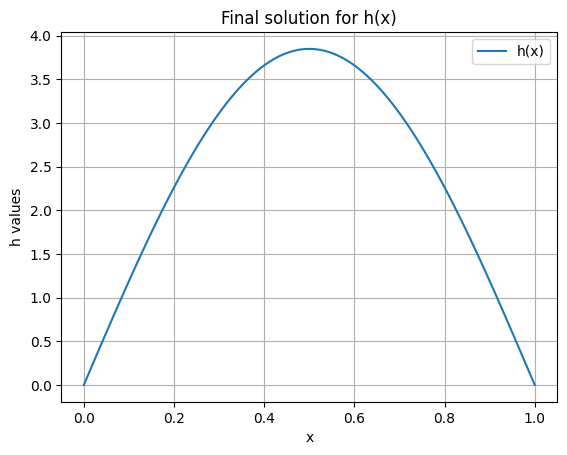

Final coefficients: c1=0.03, c2=0.33, c3=0.13



In [ ]:
#h(x)
plt.plot(x, h, label='h(x)')
plt.xlabel('x')
plt.ylabel('h values')
plt.title('Final solution for h(x)')
plt.legend()
plt.grid(True)
plt.show()
print(f"Final coefficients: c1={round(c1,2)}, c2={round(c2,2)}, c3={round(c3,2)}\n")

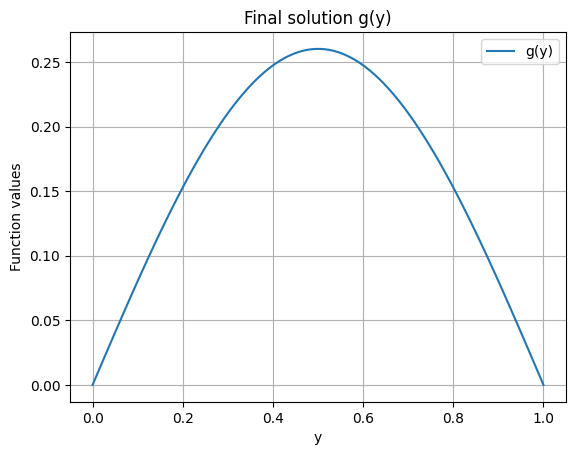

Final coefficients: k1=7.4, k2=72.99, k3=1.92


In [ ]:
#g(x)
plt.plot(y, g, label='g(y)')
plt.xlabel('y')
plt.ylabel('Function values')
plt.title('Final solution g(y)')
plt.legend()
plt.grid(True)
plt.show()
print(f"Final coefficients: k1={round(k1,2)}, k2={round(k2,2)}, k3={round(k3,2)}")

Now we consider the more general case that corresponds to the `full IGKM` method:
$$
u(x,y) = \sum_{i=1}^{M}h_i(x)g_i(y)\\
J=\int_{0}^{1} \int_{0}^{1} [~(\sum_{i=1}^{M}h_i' g_i)^2 + (\sum_{i=1}^{M}h_i g_i')^2 - 4\pi^2 sin(\pi x)sin(\pi y) (\sum_{i=1}^{M}h_ig_i)~] ~ dxdy\\
L_x(h_1... h_M,h_1'...h_M') = \int_{0}^{1} [~(\sum_{i=1}^{M}h_i' g_i)^2 + (\sum_{i=1}^{M}h_i g_i')^2 - 4\pi^2 sin(\pi x)sin(\pi y) (\sum_{i=1}^{M}h_ig_i)~] ~ dy\\
L_y(g_1... g_M,g_1'...g_M') = \int_{0}^{1} [~(\sum_{i=1}^{M}h_i' g_i)^2 + (\sum_{i=1}^{M}h_i g_i')^2 - 4\pi^2 sin(\pi x)sin(\pi y) (\sum_{i=1}^{M}h_ig_i)~] ~ dx\\
\text{Euler-Lagrange equation (for x or y variable): } \dfrac{\partial L}{\partial f_k} - \dfrac{d}{dx}(\dfrac{\partial L}{\partial f_k'}) = 0
$$

After calculations for an arbitrary integer value $ 1\leq k \leq M$, we get the following equations;<br>
 First, the boundary value problem for $h_k$:
$$
\sum_{i=1}^{M} C_{1ki} \dfrac{d^2h_i}{dx^2}(x) - \sum_{i=1}^{M} C_{2ki}~h_i(x) + 2 C_{3k} \pi^2 sin(\pi x)=0\\
h_k(0) = h_k(1) = 0\\
C_{1ki} = \int_{0}^{1} g_k g_i dy\\
C_{2ki} = \int_{0}^{1} g_k'g_i' dy\\
C_{3k} = \int_{0}^{1} sin(\pi y)g_k(y) dy\\
$$

Second, the boundary value problem for $g_k$:
$$
\sum_{i=1}^{M} D_{1ki} \dfrac{d^2g_i}{dy^2}(y) - \sum_{i=1}^{M} D_{2ki}~g_i(y) + 2 D_{3k} \pi^2 sin(\pi y)=0\\
g_k(0) = g_k(1) = 0\\
D_{1ki} = \int_{0}^{1} h_k h_i dx\\
D_{2ki} = \int_{0}^{1} h_k'h_i' dx\\
D_{3k} = \int_{0}^{1} sin(\pi x)h_k(x) dx\\
$$<br>
We can of course separate the functions $h_k$ and $g_k$ in these equations to make it clearer, as every time we will be solving for one function, $h_k$ for example, and consider the rest as non linear terms since in the IGKM algorithm we're supposed to have an expression for the rest of functions, $h_i$ for $i \neq k$.<br>
What is left now is to implement this into python similarly to before, starting from $M=2$ until convergence where the solution dosen't change anymore after increasing $M$ value.